## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:10])

3718
196
[[('Young', 'NOUN'), ("'s", 'PRT'), ('Market', 'NOUN'), ('Co.', 'NOUN'), (',', '.'), ('a', 'DET'), ('wholesaler', 'NOUN'), ('of', 'ADP'), ('spirits', 'NOUN'), (',', '.'), ('wines', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('goods', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('will', 'VERB'), ('merge', 'VERB'), ('with', 'ADP'), ('a', 'DET'), ('new', 'ADJ'), ('corporation', 'NOUN'), ('formed', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('Underwood', 'NOUN'), ('family', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('controls', 'VERB'), ('Young', 'NOUN'), ("'s", 'PRT'), ('.', '.')], [('When', 'ADV'), ('the', 'DET'), ('company', 'NOUN'), ('asked', 'VERB'), ('members', 'NOUN'), ('in', 'ADP'), ('a', 'DET'), ('mailing', 'NOUN'), ('which', 'DET'), ('cars', 'NOUN'), ('they', 'PRON'), ('would', 'VERB'), ('like', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('get', 'VERB'), ('information', 'NOUN'), ('about', 'ADP'), ('*T*-2', 'X'), ('for', 'ADP'), ('

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95619

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Young', "'s", 'Market', 'Co.', ',', 'a', 'wholesaler', 'of', 'spirits', ',']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12051


In [8]:
# tags
tags = [pair[1] for pair in train_tagged_words]

In [9]:
# the most frequent tag in the train_set
from collections import Counter
tag_counts = Counter(tags)
tag_counts.most_common(5)

[('NOUN', 27373), ('VERB', 12884), ('.', 11154), ('ADP', 9350), ('DET', 8292)]

In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
print(T)

{'CONJ', 'PRON', 'VERB', 'ADV', 'NUM', 'X', 'ADJ', 'PRT', 'NOUN', '.', 'ADP', 'DET'}


### Build the vanilla Viterbi based POS tagger

##### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# tweet
print("\n", "tweet")
print(word_given_tag('tweet', 'NOUN'))
print(word_given_tag('tweet', 'VERB'))
print(word_given_tag('tweet', 'ADJ'), "\n")

# makes
print("\n", "makes")
print(word_given_tag('makes', 'NOUN'))
print(word_given_tag('makes', 'VERB'))
print(word_given_tag('makes', 'ADJ'))



 tweet
(0, 27373)
(0, 12884)
(0, 6076) 


 makes
(0, 27373)
(9, 12884)
(0, 6076)


##### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('ADJ', 'VERB'))
print(t2_given_t1('VERB', 'NOUN'))

(6574, 27373)
(837, 12884)
(4020, 27373)


In [17]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))

(2476, 11154)
(991, 11154)


In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
tags_matrix

array([[4.69043152e-04, 6.00375235e-02, 1.53377116e-01, 5.48780486e-02,
        4.17448394e-02, 8.44277628e-03, 1.15384616e-01, 4.69043152e-03,
        3.51782352e-01, 3.61163244e-02, 5.30018769e-02, 1.20075047e-01],
       [5.33333328e-03, 7.61904754e-03, 4.86095250e-01, 3.39047611e-02,
        7.61904754e-03, 9.29523781e-02, 7.16190487e-02, 1.29523808e-02,
        2.09523812e-01, 3.99999991e-02, 2.28571426e-02, 9.52380989e-03],
       [5.27786417e-03, 3.56255807e-02, 1.68425947e-01, 8.24278146e-02,
        2.29742322e-02, 2.16935739e-01, 6.49642944e-02, 3.22104953e-02,
        1.10835142e-01, 3.50046568e-02, 9.08103064e-02, 1.34507909e-01],
       [6.61594421e-03, 1.55474693e-02, 3.44359905e-01, 7.90605396e-02,
        3.07641421e-02, 2.34866031e-02, 1.30995706e-01, 1.45550780e-02,
        3.14257368e-02, 1.35957658e-01, 1.17763810e-01, 6.94674179e-02],
       [1.30563797e-02, 1.48367952e-03, 1.86943617e-02, 2.96735903e-03,
        1.86350152e-01, 2.12166175e-01, 3.38278934e-02, 2.55

In [20]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [21]:
tags_df

,CONJ,PRON,VERB,ADV,NUM,X,ADJ,PRT,NOUN,.,ADP,DET
CONJ,0.000469,0.060038,0.153377,0.054878,0.041745,0.008443,0.115385,0.004690,0.351782,0.036116,0.053002,0.120075
PRON,0.005333,0.007619,0.486095,0.033905,0.007619,0.092952,0.071619,0.012952,0.209524,0.040000,0.022857,0.009524
VERB,0.005278,0.035626,0.168426,0.082428,0.022974,0.216936,0.064964,0.032210,0.110835,0.035005,0.090810,0.134508
ADV,0.006616,0.015547,0.344360,0.079061,0.030764,0.023487,0.130996,0.014555,0.031426,0.135958,0.117764,0.069467
NUM,0.013056,0.001484,0.018694,0.002967,0.186350,0.212166,0.033828,0.025519,0.349258,0.118101,0.035312,0.003264
X,0.009884,0.056432,0.204527,0.024868,0.002869,0.074127,0.016738,0.184601,0.062171,0.164833,0.144907,0.054041
ADJ,0.016623,0.000658,0.012344,0.004937,0.020573,0.021066,0.066656,0.010698,0.698650,0.065339,0.077518,0.004937
PRT,0.002282,0.018259,0.400717,0.009455,0.055429,0.014020,0.084773,0.001956,0.246169,0.043691,0.020541,0.102706
NOUN,0.042231,0.004749,0.146860,0.017024,0.009389,0.029116,0.012348,0.044168,0.263764,0.240164,0.176890,0.013298
.,0.058096,0.066434,0.088847,0.053165,0.080689,0.027165,0.043661,0.002241,0.221983,0.094047,0.090461,0.173122


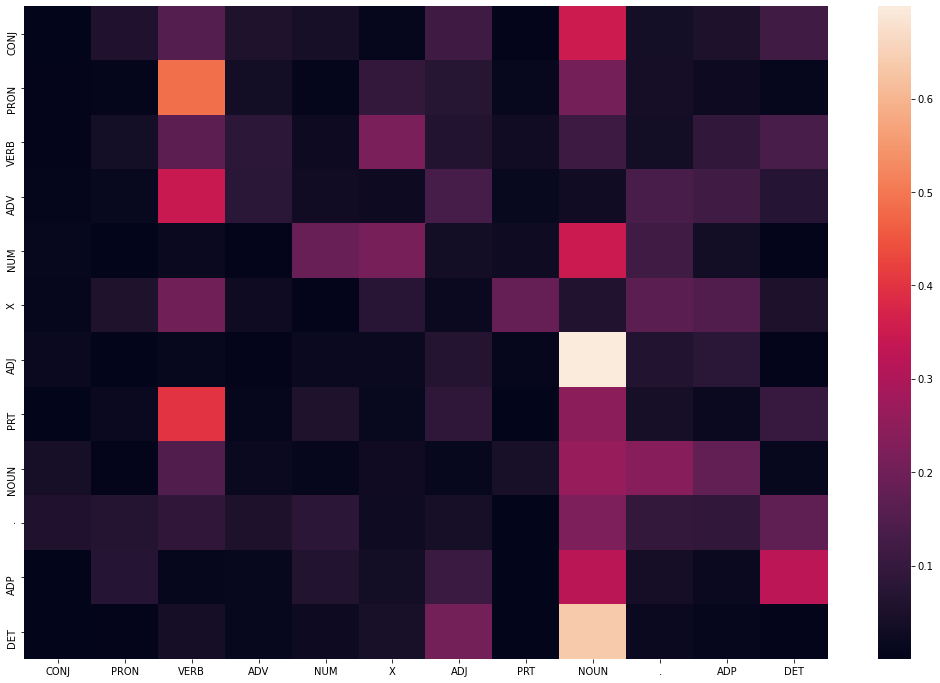

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

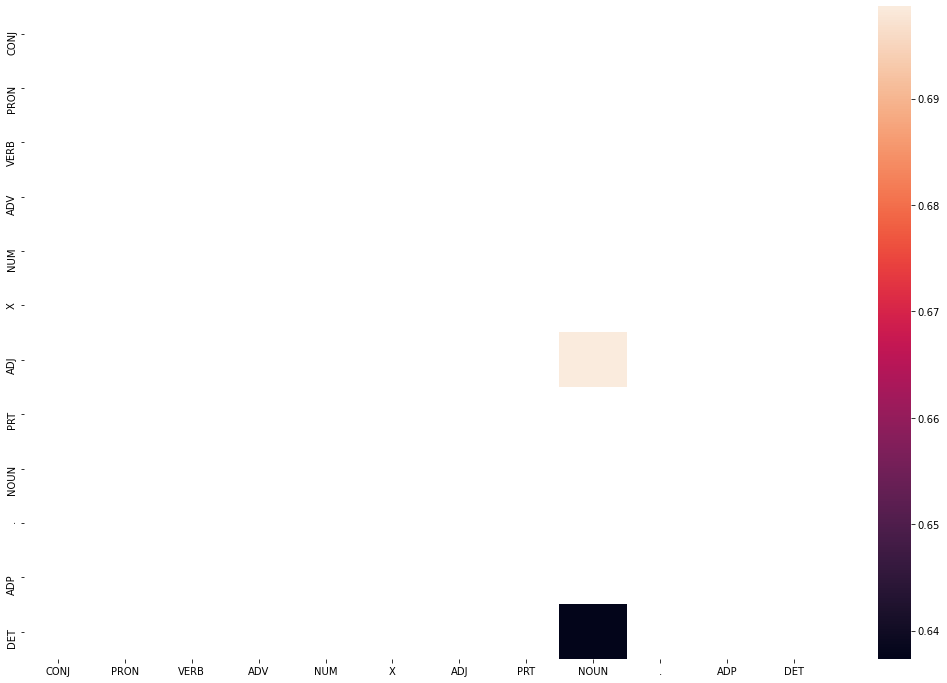

In [23]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag/previous tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [24]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Test Set

In [25]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('It', 'PRON'),
  ('was', 'VERB'),
  ('full', 'ADJ'),
  ('of', 'ADP'),
  ('violence', 'NOUN'),
  ('and', 'CONJ'),
  ('gangs', 'NOUN'),
  ('and', 'CONJ'),
  ('kids', 'NOUN'),
  ('cutting', 'VERB'),
  ('class', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Linda', 'NOUN'),
  ('Ward', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('school', 'NOUN'),
  ("'s", 'PRT'),
  ('principal', 'NOUN'),
  ('.', '.')],
 [('One', 'NUM'),
  ('investment', 'NOUN'),
  ('banker', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Mr.', 'NOUN'),
  ('Steinberg', 'NOUN'),
  ('may', 'VERB'),
  ('be', 'VERB'),
  ('trying', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('position', 'VERB'),
  ('himself', 'PRON'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('friendly', 'ADJ'),
  ('investor', 'NOUN'),
  ('who', 'PRON'),
  ('*T*-1', 'X'),
  ('could', 'VERB'),
  ('help', 'VERB'),
  ('UAL', 'NOUN'),
  ('Chairman', 'NOUN'),
  ('Stephen', 'NOUN'),
  ('Wolf', 'NOUN'),
  ('revive', 'VERB'

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  23.89123034477234
[('``', '.'), ('It', 'PRON'), ('was', 'VERB'), ('full', 'ADJ'), ('of', 'ADP'), ('violence', 'NOUN'), ('and', 'CONJ'), ('gangs', 'CONJ'), ('and', 'CONJ'), ('kids', 'NOUN'), ('cutting', 'VERB'), ('class', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Linda', 'NOUN'), ('Ward', 'NOUN'), (',', '.'), ('the', 'DET'), ('school', 'NOUN'), ("'s", 'PRT'), ('principal', 'ADJ'), ('.', '.'), ('One', 'NUM'), ('investment', 'NOUN'), ('banker', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Steinberg', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('trying', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('position', 'NOUN'), ('himself', 'PRON'), ('as', 'ADP'), ('a', 'DET'), ('friendly', 'ADJ'), ('investor', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('could', 'VERB'), ('help', 'VERB'), ('UAL', 'NOUN'), ('Chairman', 'NOUN'), ('Stephen', 'NOUN'), ('Wolf', 'NOUN'), ('revive', 'VERB'), ('a', 'DET'), ('failed', 'VERB'), ('labor-management', 'AD

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

0.9523809523809523

In [28]:
# Incorrect tagged cases by Viterbi Algorithm
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('and', 'CONJ'), (('gangs', 'CONJ'), ('gangs', 'NOUN'))],
 [("'s", 'PRT'), (('principal', 'ADJ'), ('principal', 'NOUN'))],
 [('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('in', 'ADP'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))]]

In [29]:
## Testing on Test_sentences.txt file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq1 = Viterbi(words)
end = time.time()
difference = end-start


##### Set of unknown words in Test_sentence.txt file

In [30]:
unknown_words = [x for x in words if x not in tokens]

In [31]:
print(set(unknown_words))

{'Twitter', 'tournament', '2013', '2015', '21st', 'contested', 'invited', '2011', 'Satellite', 'domineering', 'ICESAT-2', 'smartphones', 'personality', 'firehose', 'Cup', 'trips', 'NASA', 'tweets', 'online', 'Android', 'interact', 'FIFA', '2018', 'Google', 'worldwide', 'arriving', 'OS', 'messages'}


In [32]:
print(tagged_seq1)
print(difference)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'CONJ'), ('.', '.'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'CONJ'), ('.', '.'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'CONJ'), ("'s", 'VERB'), ('firehose', 'CONJ'), ('.', '.'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'

##### Most of the unknown_words are tagged as NUMBER

#### Solve the problem of unknown words

### Version 1 : Rule Based Tagging with Viterbi

In [33]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        return v[1]

In [34]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('It', 'PRON'),
  ('was', 'VERB'),
  ('full', 'ADJ'),
  ('of', 'ADP'),
  ('violence', 'NOUN'),
  ('and', 'CONJ'),
  ('gangs', 'NOUN'),
  ('and', 'CONJ'),
  ('kids', 'NOUN'),
  ('cutting', 'VERB'),
  ('class', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Linda', 'NOUN'),
  ('Ward', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('school', 'NOUN'),
  ("'s", 'PRT'),
  ('principal', 'NOUN'),
  ('.', '.')],
 [('One', 'NUM'),
  ('investment', 'NOUN'),
  ('banker', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Mr.', 'NOUN'),
  ('Steinberg', 'NOUN'),
  ('may', 'VERB'),
  ('be', 'VERB'),
  ('trying', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('position', 'VERB'),
  ('himself', 'PRON'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('friendly', 'ADJ'),
  ('investor', 'NOUN'),
  ('who', 'PRON'),
  ('*T*-1', 'X'),
  ('could', 'VERB'),
  ('help', 'VERB'),
  ('UAL', 'NOUN'),
  ('Chairman', 'NOUN'),
  ('Stephen', 'NOUN'),
  ('Wolf', 'NOUN'),
  ('revive', 'VERB'

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

In [37]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  23.761845588684082
[('``', '.'), ('It', 'PRON'), ('was', 'VERB'), ('full', 'ADJ'), ('of', 'ADP'), ('violence', 'NOUN'), ('and', 'CONJ'), ('gangs', 'NOUN'), ('and', 'CONJ'), ('kids', 'NOUN'), ('cutting', 'VERB'), ('class', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Linda', 'NOUN'), ('Ward', 'NOUN'), (',', '.'), ('the', 'DET'), ('school', 'NOUN'), ("'s", 'PRT'), ('principal', 'ADJ'), ('.', '.'), ('One', 'NUM'), ('investment', 'NOUN'), ('banker', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Steinberg', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('trying', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('position', 'NOUN'), ('himself', 'PRON'), ('as', 'ADP'), ('a', 'DET'), ('friendly', 'ADJ'), ('investor', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('could', 'VERB'), ('help', 'VERB'), ('UAL', 'NOUN'), ('Chairman', 'NOUN'), ('Stephen', 'NOUN'), ('Wolf', 'NOUN'), ('revive', 'VERB'), ('a', 'DET'), ('failed', 'VERB'), ('labor-management', 'A

In [38]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9603174603174603


In [39]:
# Incorrect tagged cases by Rule Based Tagging with Viterbi
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('principal', 'ADJ'), ('principal', 'NOUN'))],
 [('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('in', 'ADP'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))]]

In [40]:
#Test on the given file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

In [41]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Version 2 : Lexicon and Rule Based Tagging with Viterbi

In [42]:

def lexicon_and_rule_based_tagging(word):
    rule_based_tagger = nltk.RegexpTagger(pattern)
    lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
    #kv = lexicon_tagger.tag(nltk.word_tokenize(word))
    return lexicon_tagger.tag_sents([[(word)]])

In [43]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_and_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word not in V:
            unk_word_tag=lexicon_and_rule_based_tagging(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            pmax = max(p)
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [44]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('It', 'PRON'),
  ('was', 'VERB'),
  ('full', 'ADJ'),
  ('of', 'ADP'),
  ('violence', 'NOUN'),
  ('and', 'CONJ'),
  ('gangs', 'NOUN'),
  ('and', 'CONJ'),
  ('kids', 'NOUN'),
  ('cutting', 'VERB'),
  ('class', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Linda', 'NOUN'),
  ('Ward', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('school', 'NOUN'),
  ("'s", 'PRT'),
  ('principal', 'NOUN'),
  ('.', '.')],
 [('One', 'NUM'),
  ('investment', 'NOUN'),
  ('banker', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Mr.', 'NOUN'),
  ('Steinberg', 'NOUN'),
  ('may', 'VERB'),
  ('be', 'VERB'),
  ('trying', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('position', 'VERB'),
  ('himself', 'PRON'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('friendly', 'ADJ'),
  ('investor', 'NOUN'),
  ('who', 'PRON'),
  ('*T*-1', 'X'),
  ('could', 'VERB'),
  ('help', 'VERB'),
  ('UAL', 'NOUN'),
  ('Chairman', 'NOUN'),
  ('Stephen', 'NOUN'),
  ('Wolf', 'NOUN'),
  ('revive', 'VERB'

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_and_rule_based(test_tagged_words)
end = time.time()
difference = end-start

In [46]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  26.053945302963257
[('``', '.'), ('It', 'PRON'), ('was', 'VERB'), ('full', 'ADJ'), ('of', 'ADP'), ('violence', 'NOUN'), ('and', 'CONJ'), ('gangs', 'NOUN'), ('and', 'CONJ'), ('kids', 'NOUN'), ('cutting', 'VERB'), ('class', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Linda', 'NOUN'), ('Ward', 'NOUN'), (',', '.'), ('the', 'DET'), ('school', 'NOUN'), ("'s", 'PRT'), ('principal', 'ADJ'), ('.', '.'), ('One', 'NUM'), ('investment', 'NOUN'), ('banker', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Steinberg', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('trying', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('position', 'NOUN'), ('himself', 'PRON'), ('as', 'ADP'), ('a', 'DET'), ('friendly', 'ADJ'), ('investor', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('could', 'VERB'), ('help', 'VERB'), ('UAL', 'NOUN'), ('Chairman', 'NOUN'), ('Stephen', 'NOUN'), ('Wolf', 'NOUN'), ('revive', 'VERB'), ('a', 'DET'), ('failed', 'VERB'), ('labor-management', 'A

In [47]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9603174603174603


In [48]:
# Incorrect tagged cases by Lexicon Rule Based Tagging with Viterbi
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('principal', 'ADJ'), ('principal', 'NOUN'))],
 [('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('in', 'ADP'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))]]

In [49]:
# Test on the given file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

In [50]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Version3: Probabilistic Viterbi Algorithm

In [51]:
# use transition probability of tags when emission probability is zero (in case of unknown words)
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
        
        pmax = max(p)
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                                      
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [52]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('It', 'PRON'),
  ('was', 'VERB'),
  ('full', 'ADJ'),
  ('of', 'ADP'),
  ('violence', 'NOUN'),
  ('and', 'CONJ'),
  ('gangs', 'NOUN'),
  ('and', 'CONJ'),
  ('kids', 'NOUN'),
  ('cutting', 'VERB'),
  ('class', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Linda', 'NOUN'),
  ('Ward', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('school', 'NOUN'),
  ("'s", 'PRT'),
  ('principal', 'NOUN'),
  ('.', '.')],
 [('One', 'NUM'),
  ('investment', 'NOUN'),
  ('banker', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Mr.', 'NOUN'),
  ('Steinberg', 'NOUN'),
  ('may', 'VERB'),
  ('be', 'VERB'),
  ('trying', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('position', 'VERB'),
  ('himself', 'PRON'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('friendly', 'ADJ'),
  ('investor', 'NOUN'),
  ('who', 'PRON'),
  ('*T*-1', 'X'),
  ('could', 'VERB'),
  ('help', 'VERB'),
  ('UAL', 'NOUN'),
  ('Chairman', 'NOUN'),
  ('Stephen', 'NOUN'),
  ('Wolf', 'NOUN'),
  ('revive', 'VERB'

In [53]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

In [54]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  23.333152532577515
[('``', '.'), ('It', 'PRON'), ('was', 'VERB'), ('full', 'ADJ'), ('of', 'ADP'), ('violence', 'NOUN'), ('and', 'CONJ'), ('gangs', 'NOUN'), ('and', 'CONJ'), ('kids', 'NOUN'), ('cutting', 'VERB'), ('class', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Linda', 'NOUN'), ('Ward', 'NOUN'), (',', '.'), ('the', 'DET'), ('school', 'NOUN'), ("'s", 'PRT'), ('principal', 'ADJ'), ('.', '.'), ('One', 'NUM'), ('investment', 'NOUN'), ('banker', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Steinberg', 'NOUN'), ('may', 'VERB'), ('be', 'VERB'), ('trying', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('position', 'NOUN'), ('himself', 'PRON'), ('as', 'ADP'), ('a', 'DET'), ('friendly', 'ADJ'), ('investor', 'NOUN'), ('who', 'PRON'), ('*T*-1', 'X'), ('could', 'VERB'), ('help', 'VERB'), ('UAL', 'NOUN'), ('Chairman', 'NOUN'), ('Stephen', 'NOUN'), ('Wolf', 'NOUN'), ('revive', 'VERB'), ('a', 'DET'), ('failed', 'VERB'), ('labor-management', 'A

In [196]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi1_accuracy = len(check)/len(tagged_seq)
print(viterbi1_accuracy)

0.9337748344370861


In [55]:
# Incorrect tagged cases by Probabilistic Viterbi Algorithm
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("'s", 'PRT'), (('principal', 'ADJ'), ('principal', 'NOUN'))],
 [('to', 'PRT'), (('position', 'NOUN'), ('position', 'VERB'))],
 [('failed', 'VERB'),
  (('labor-management', 'ADJ'), ('labor-management', 'NOUN'))],
 [('in', 'ADP'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('New', 'NOUN'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))]]

In [56]:
# Test on the given file
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

In [57]:
print(tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Vannila Viterbi Accuracy: 95.238

Rule based Viterbi Accuracy: 96.0317

Lexicon and Rule Based Viterbi Accuracy: 96.0317

Probabilistic Based Viterbi Accuracy: 93.3774

#### Lexicon and Rule Based Viterbi's accuracy is greater than the remaining Vannila Viterbi's accuracies

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Words like 'Twitter', 'Android', 'Google', 'FIFA', 'NASA', 'tournament', 'cup' are properly tagged with 'NOUN' in modified Viterbi Algorithm

Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' 

Integers or float like 2013, 2015, 2011, 2018 are properly tagged as 'NUM' 